In [22]:
import sys
sys.path.append("../")

In [23]:
from functions.floodmodel_utils import get_basin_mask, get_river_mask, reshape_scalar_predictand, reshape_multiday_predictand
import xarray as xr
#Creating a Dask local cluster for parallel computing (making the computations later on much faster)
from dask.distributed import Client, LocalCluster


In [24]:
#HYPERPARAMETERS
days_intake_length = 90
forecast_day = 30


#LIBRARY IMPORTS
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster


#Connecting to a cluster to be able to run the code locally/on the cloud
#cluster = LocalCluster()  # n_workers=10, threads_per_worker=1,
client = Client(processes=False)


/root/miniconda3/envs/main/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [25]:
#This will tell you where you dashboard will be so you can visualize your model being run
print(client.scheduler_info()['services'])

{'dashboard': 38857}


In [ ]:
#Loading the transformed dataset
#glofas_loaded = xr.open_dataset("/tmp/flood_prediction/pipeline/data_download:upload/reshaped_glofas_2019.nc")
glofas_loaded = xr.open_mfdataset("/mnt/bucket/stuarts_files/glofas/*/*.nc", combine="by_coords")

In [ ]:
glofas_loaded

In [ ]:
era5_loaded = xr.open_mfdataset("/mnt/bucket/stuarts_files/Elbe/reanalysis-era5-single-levels_convective_precipitation,land_sea_mask,large_scale_precipitation,runoff,slope_of_sub_gridscale_orography,soil_type,total_column_water_vapour,volumetric_soil_water_layer_1,volumetric_soil_water_layer_2_*.nc", combine="by_coords")

In [ ]:
era5_loaded

In [ ]:
era5 = era5_loaded.copy()
glofas = glofas_loaded.rename({'lon' : 'longitude'})
glofas = glofas_loaded.rename({'lat': 'latitude'})


In [ ]:
glofas

In [ ]:
elbe_basin_mask = get_basin_mask(glofas['dis24'].isel(time=0), 'Elbe')

elbe_river_mask = get_river_mask(glofas['dis24'].isel(time=0))


In [ ]:
elbe_basin_mask

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))

In [ ]:
glofas_masked = glofas.loc[period_train].where(elbe_basin_mask, drop=True).where(elbe_river_mask, drop=True)

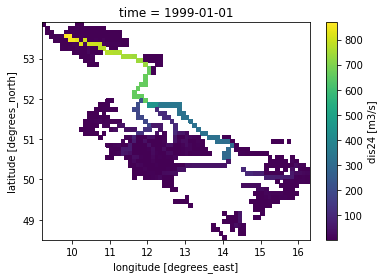

In [40]:
glofas_masked['dis24'].isel(time=0).plot()

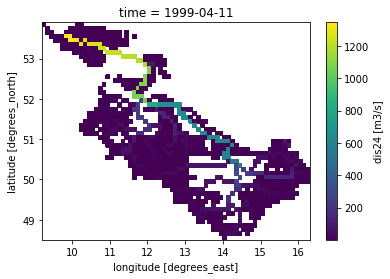

In [41]:
glofas_masked['dis24'].isel(time=100).plot()

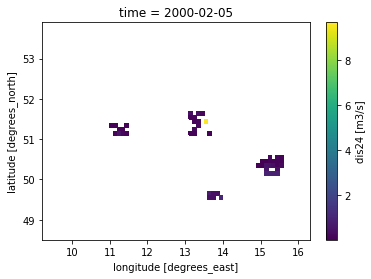

In [42]:
glofas_masked['dis24'].isel(time=400).plot()

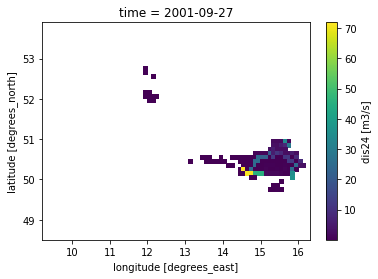

In [43]:
glofas_masked['dis24'].isel(time=1000).plot()

In [44]:
glofas_masked2 = glofas.loc[period_valid].where(elbe_basin_mask, drop=True)

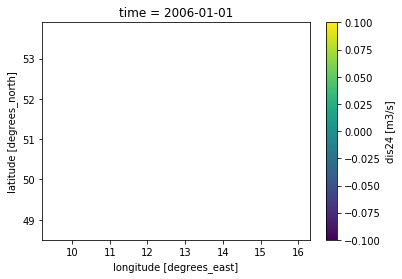

In [45]:
glofas_masked2['dis24'].isel(time=0).plot()

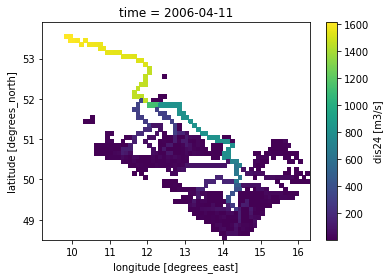

In [47]:
glofas_masked2['dis24'].isel(time=100).plot()

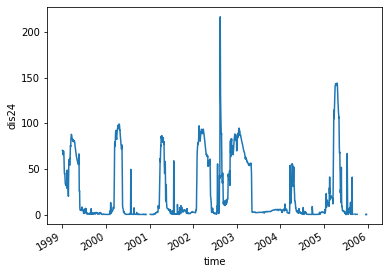

In [48]:
glofas_masked['dis24'].mean(['latitude','longitude']).plot()

In [51]:
flood_cases = glofas_masked2['dis24'].mean(['latitude','longitude']).where(glofas_masked2['dis24'].mean(['latitude','longitude'])>100)

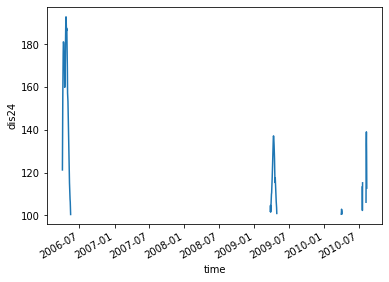

In [52]:
flood_cases.plot()

In [ ]:
glofas_river_masked['dis24'].isel(time=0).plot()

In [ ]:
y_orig = glofas_masked
#Making a copy because y will be transformed to represent the variation of discharge. The model will be predicting the variation of discharge, not the quantity of discharge itself
y = y_orig.copy()

#Era5 will be the predictor dataset


In [ ]:
#Reshape to align in coordinates
era5_masked = era5.loc[period_train].interp(latitude=glofas_masked.latitude, longitude=glofas_masked.longitude).where(elbe_basin_mask, drop=True)
X = era5_masked


#Downsampling our time from hourly to daily
X = X.resample(time='1D').mean()


In [ ]:
X

In [ ]:
y

In [ ]:
#Reshape to align in time
from tqdm import tqdm
for i in tqdm(range(0, len(X.latitude))):

    for j in range(0, len(X.longitude)):
        
        if i==0 and j==0:
            Xda, yda = X.isel(latitude=i, longitude=j).to_array(dim='features').T , y.isel(latitude=i, longitude=j).to_array(dim='features').T
            
        else:
            XdaNew, ydaNew = X.isel(latitude=i, longitude=j).to_array(dim='features').T, y.isel(latitude=i, longitude=j).to_array(dim='features').T

            Xda = xr.concat([Xda, XdaNew], 'points')
            yda = xr.concat([yda, ydaNew], 'points')
            



In [ ]:
Xda.to_netcdf('./elbe.nc')

In [ ]:
yda.to_netcdf('./elbeglofas.nc')

In [ ]:
Xda

In [ ]:
yda

In [ ]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
y_train_scaled = y_train
#I'm hesitating whether I should apply standard scaling on the output
# sc2 = MinMaxScaler(feature_range=(0,1))
# y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))
X_train = []
y_train_array = []

coordinate_array = []

#tqdm, itertools.product.
#Iterating through each feature, shifting the time for each feature, and appending the time-shifted feature array to X_train for a total of 16 times
for n in range(len(X_train.data_vars)):

    feature_array = []
    #For every latitude coordinate:
    for j in range(len(X_train.latitude)):

        for k in range(len(X_train.longitude)):

            for l in range(60, len(X_train_scaled)):

                feature_array.append(X_train.isel(latitude=j, longitude=k)[l - days_intake_length:l, n])




            coordinate_array.append(feature_array)
            feature_array = []




    X_train.append(coordinate_array)

